# Bachelor thesis demo

**Thesis title**: Generative methods applicable for data anonymization and test data creation in the banking industry

<hr/>

This notebook is a part of a bachelor thesis at FIT, CTU in Prague. It contains a demonstrational implementation of a CTGAN model, which is trained on a production dataset provided by Komerční Banka. The dataset is used in practice as a learning dataset for a classification model, which aims to predict a binary flag (**GOOD_BAD**). 

The notebook shows data preprocessing and analysis of the dataset. Based on that, the dataset is then used to train a CTGAN synthesizer and a fully synthetic dataset is sampled. It is then evaluated against the original dataset used for the synthesizer training.

### Initial imports:

In [1]:
import os

import pandas as pd
import numpy as np
import sklearn

import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import time

## Config

Contains configuration for this notebook. 

It can be used to configure paths, set different split ratios or skip certain parts of the demonstration.

<hr/>

Flags:

* <b>TRAIN_MODEL</b>: Determines whether a new synthesizer is trained or not.
* <b>SYNTHESIZE_DATA</b>: Determines whether a new synthetic dataset is sampled or not.
* <b>COMPUTE_ML_EFFICACY</b>: Determines whether the notebook runs a ML efficacy or not.
* <b>COMPUTE_STATISTICS</b>: Determines whether the notebook runs all statistical or not.
* <b>PLOT_DISTRIBUTIONS</b>: Determines whether the notebook plots marginal distributions of all datasets or not.
    
Data paths:

* <b>DATA_PATH_REAL</b>: Path to a .csv file with a real dataset.
* <b>DATA_PATH_SYNTH_RAW</b>: Path to a .csv file with a freshly generated synthetic dataset.
* <b>DATA_PATH_SYNTH_FINAL</b>: Path to a .csv file with a synthetic dataset after it is transformed to the original format.
* <b>MODEL_PATH</b>: Path to a pre-trained synthesizer.

Training & ratios:

* <b>TARGET_VAR_NAME</b>: Name of a target variable column.
* <b>SAMPLING_RATIO</b>: Downsample ratio for each class of the target variable column (for values <b>0</b> and <b>1</b> respectively)
* <b>SPLIT_TRAIN_TEST</b>: Train data x test data split ratio (e.g. 0.1 means 90 % of the data remain in the train dataset, 10 % in the test dataset.
* <b>SDV_EVAL_SPLIT</b>: Ratio of data used for SDV evaluation.

Other:
* <b>RANDOM_SEED</b>: Seed for random processes to keep stable results.

In [2]:
TRAIN_MODEL = False
SYNTHESIZE_DATA = False
COMPUTE_ML_EFFICACY = True
COMPUTE_STATISTICS = True
PLOT_DISTRIBUTIONS = True

DATA_PATH_REAL = 'data/rad/data_rad_anonym.csv'
DATA_PATH_SYNTH_RAW = 'data/rad/bp_data.csv'
DATA_PATH_SYNTH_FINAL = 'data/rad/bp_data_out.csv'
MODEL_PATH = 'model/bp_model.pkl'

TARGET_VAR_NAME = 'GOOD_BAD'
SAMPLING_RATIO = (1, 0.2)
SPLIT_TRAIN_TEST = 0.3
SDV_EVAL_SPLIT = 0.5

RANDOM_SEED = 21

"""
--------------------------------------------------------
                    config asserts
--------------------------------------------------------
""" 
    
assert os.path.exists(DATA_PATH_REAL), 'The real data path is not defined.'
assert TRAIN_MODEL or os.path.exists(DATA_PATH_REAL), 'The model path is not defined.'
assert SYNTHESIZE_DATA or os.path.exists(DATA_PATH_REAL), 'The synthetic data path is not defined.'

assert all([0 <= x <= 1 for x in (*SAMPLING_RATIO, SPLIT_TRAIN_TEST)]), 'All ratios have to be from range 0 to 1.'

**CTGAN hyperparams:**

Default hyperparameters are used now.

In [3]:
HYPERPARAMS = {
    'batch_size': 500,
    'epochs': 300,
    'discriminator_steps': 5,
    'generator_lr': 2e-4,
    'discriminator_lr': 2e-4,
    'verbose': True,
    'constraints': []
}

In [4]:
def add_constraint(c):
    """
    Adds new constraint to the model hyperparameters
    """
    tmp = HYPERPARAMS['constraints']
    tmp.append(c)
    HYPERPARAMS['constraints'] = tmp

**Imports:**

In [5]:
import pandas as pd
import numpy as np
import sklearn

import matplotlib.pyplot as plt

import time

**Disabling warnings** 



In [6]:
import warnings
warnings.filterwarnings('ignore')

## Helper functions

In [7]:
def to_percent(x):
    """
    Converts decimal number percentage string representation 
    """
    return f'{(x * 100):.2f} %'

def drop_col_safe(data: pd.DataFrame, col):
    """
    Drops column from the dataframe
    """
    if col in data.columns:
        print(f'{col} column dropped.')
        data.drop(col, axis=1, inplace=True)

In [8]:
import time


def measure_time(f):
    """
    Decorates the function with time measuring

    The time is returned as the second parameter
    """
    def wrapper(*args, **kwargs):
        # start the clock
        time_init = time.time()
        # call the function
        res = f(*args, **kwargs)
        # return the function result and the time of execution
        return res, time.time() - time_init
    return wrapper

## Data load

For demonstrative purpose, the data are loaded from a .csv file defined in the config (instead of using an ODBC driver). 

In [9]:
df_ = pd.read_csv(DATA_PATH_REAL)

display(df_.sample(3, random_state=RANDOM_SEED))
display(df_.info())

ID          V2  GOOD_BAD   V4        V5        V6    V7  \
63753  141168595  30.06.2013         1  NaN  63467,83  48773,00  0,21   
92837  151795752  31.08.2013         1  NaN   3638,49  14281,00  0,12   
73916  145468675  30.09.2009         1  NaN   5063,84       NaN  0,05   

                      V8        V9       V10  ...  V17  V18  V19  V20 V21  \
63753  -0,54976761077606     35954  13816,00  ...  0.0  0.0  0.0  0.0   0   
92837  0,152309443043902     11789   2580,00  ...  0.0  0.0  0.0  0.0   1   
73916                NaN  17782,04       NaN  ...  NaN  NaN  NaN  NaN   1   

              V22       V23   V24   V25        V26  
63753  2582602,28  29000,00  1,00  0,00  307279,16  
92837    78200,48  14000,00  1,00  0,00    3638,49  
73916         NaN       NaN  1,00  0,00        NaN  

[3 rows x 26 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233035 entries, 0 to 233034
Data columns (total 26 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ID        233035 non-null  int64  
 1   V2        233035 non-null  object 
 2   GOOD_BAD  233035 non-null  int64  
 3   V4        63922 non-null   object 
 4   V5        206559 non-null  object 
 5   V6        167130 non-null  object 
 6   V7        224617 non-null  object 
 7   V8        93326 non-null   object 
 8   V9        233035 non-null  object 
 9   V10       182523 non-null  object 
 10  V11       182523 non-null  object 
 11  V12       182523 non-null  object 
 12  V13       233035 non-null  object 
 13  V14       151936 non-null  float64
 14  V15       173353 non-null  object 
 15  V16       149576 non-null  float64
 16  V17       182523 non-null  float64
 17  V18       151937 non-null  float64
 18  V19       151937 non-null  float64
 19  V20       151937 non-null  float64
 20  V21 

None

## Data down-sampling

Only simple selective down-sampling is implemented. Although the CTGAN model solves class inbalances on its own, the sampling allows experiments with different target variable ratios and allows to run the notebook faster when necessary. The sampling ratios are defined in the config.

In [10]:
import random


def _display_ratio_stats(value_counts: dict):
    """
    Displays number of points passed & their ratios, formatted 
    """
    n = sum(value_counts.values())
    
    print(f'Number of points:')
    for label, count in value_counts.items():
         print(f"  label '{label}': {count}")
    
    value_ratios = {k: v / n for k, v in value_counts.items()}
    print(f'Ratios:')
    for label, ratio in value_ratios.items():
         print(f"  label '{label}': {to_percent(ratio)}")

def sample_labeled_bin(data, frac_0, frac_1, verbose=False):
    """
    Samples data from the dataset based on the TARGET_VAR_NAME label
    """
    if verbose:
        # log initial state
        print('** BEFORE **\n')
        _display_ratio_stats(data[TARGET_VAR_NAME].value_counts().to_dict())
    
    # split the data based on the label & sample
    data_0 = data[data[TARGET_VAR_NAME] == 0].sample(frac=frac_0, random_state=RANDOM_SEED)
    data_1 = data[data[TARGET_VAR_NAME] == 1].sample(frac=frac_1, random_state=RANDOM_SEED)
    # merge back together
    data_res = pd.concat([data_0, data_1])
    
    if verbose:
        # log result
        print('\n** AFTER **\n')
        _display_ratio_stats({'1': data_1.shape[0], '0': data_0.shape[0]})
        n_from, n_to = data.shape[0], data_res.shape[0]
        print(f'\nData sampling result: {n_from} -> {n_to}')
        
    return data_res

In [11]:
df = sample_labeled_bin(df_, SAMPLING_RATIO[0], SAMPLING_RATIO[1], verbose=True)
df.reset_index(inplace=True)

** BEFORE **

Number of points:
  label '1': 219031
  label '0': 14004
Ratios:
  label '1': 93.99 %
  label '0': 6.01 %

** AFTER **

Number of points:
  label '1': 43806
  label '0': 14004
Ratios:
  label '1': 75.78 %
  label '0': 24.22 %

Data sampling result: 233035 -> 57810


## Data preprocessing

This part of the notebook explores the dataset and preprocesses the dataset so that it can be used to train a CTGAN synthesizer.

### Dropping the ID column:

The column is unique identifier of a row and has no value for the generator. All synthetic rows can later be assigned wny IDs based on the task they are meant for. 

In [12]:
drop_col_safe(df, 'ID')

ID column dropped.


### Converting date column

There is one date column in the dataset. It needs to be converted into an integer so that a synthesizer can learn its distribution. Although there are many ways to represent dates as integers, a good way here is to simply normalize the dates from 0 to n, where n is the difference in days between the first and the last date in the dataset. There are no gaps in this simple data format so it behaves just like any other integer.

In [13]:
date_col = 'V2'
date_col_format = '%d.%m.%Y'

Helper class for date conversion:

In [14]:
class DateConverter:
    """
    Allows to convert a date column to a format which is readable by the generative model
    
    The conversion can be reverted
    """
    
    def __init__(self, data: pd.Series, date_format, verbose=False):
        """
        Given a column, the converter saves its copy in a date format
        """
        # self._data = data.copy()
        self._data = data
        self._data = self._data.apply(lambda x: pd.to_datetime(x, format=date_format))
        if verbose:
            print(f'Data converted to datetime.')
            
        # find the date boundaries:
        self._date_init = self._data.min()
        date_last = self._data.max()
        self._days_total = (date_last.date() - self._date_init.date()).days
        if verbose:
            print(f'Dates from {self._date_init.date()} to {date_last.date()} ({self._days_total} days in total).')
        
    def _encode_one(self, date):
        """
        Returns number of days since the initial day
        """
        return (date - self._date_init).days
    
    def _decode_one(self, code):
        """
        Adjusts initial date by the code
        """
        return self._date_init + timedelta(days=code)
    
    def get_encoded(self):
        """
        Converts dates into the integer representation
        """
        return self._data.apply(lambda x: self._encode_one(x))
    
    def decode(self, data_encoded: pd.Series):
        """
        Decodes generated integers into a date format
        """
        return data_encoded.apply(lambda x: self._decode_one(x))
    
    def days_total(col_name):
        """
        Computes how many days there are between the first and the last date 
        """
        return self._days_total
        

Conversion within the dataset:

In [15]:
date_converter = DateConverter(df[date_col], date_format=date_col_format, verbose=True)

Data converted to datetime.
Dates from 2008-10-31 to 2013-12-31 (1887 days in total).


New integer column is added instead of the date one:

In [16]:
date_col_encoded = date_col + '_ENCODED'

if date_col in df.columns:
    # substitude date column with its integer representation
    df[date_col_encoded] = date_converter.get_encoded()
    print(f'New column added: {date_col_encoded}')
    df.drop(date_col, inplace=True, axis=1)
    print(f'Column dropped: {date_col}')
    

df[date_col_encoded].head(3)

New column added: V2_ENCODED
Column dropped: V2


0     546
1     911
2    1856
Name: V2_ENCODED, dtype: int64

### Converting categorical columns:

Finding a threshold for categorical columns:

In [17]:
cnts = list(df.nunique().unique())
cnts.sort()
print(cnts)

[2, 31, 63, 69, 144, 1175, 7782, 12814, 18415, 21408, 26426, 35230, 35593, 40783, 43596, 44211, 47940, 57810]


Marking the columns as categorical / continuous:

In [18]:
treshold_cat = 10

# categorical columns
cols_cat = [col for col in df.columns if df[col].nunique() <= treshold_cat]
# continuous columns
cols_cont = list(set(df.columns) - set(cols_cat))

print(f'Categorical columns:')
for c in cols_cat:
    print(f'  {c} ({df[c].nunique()})')

Categorical columns:
  GOOD_BAD (2)
  V15 (2)
  V16 (2)
  V17 (2)
  V18 (2)
  V19 (2)
  V21 (2)
  V24 (2)
  V25 (2)


### Incorrect formats in numeric columns

Some columns could not be converted, because they are incorrectly formatted.

In [19]:
obj_cols = df.select_dtypes('object').columns

df[obj_cols].head()

V4       V5        V6    V7                 V8        V9      V10  \
0  0,86      NaN       NaN  0,17                NaN      4329   545,84   
1  2,42   207,51      0,00  0,14                NaN      4245  1955,61   
2  0,01      NaN   8912,00  0,21                NaN      8912     0,00   
3  0,05   363,21       NaN   NaN                NaN      9861      NaN   
4  0,14  3959,40  28751,00  0,25  0,555194969905905  23695,98  4382,48   

        V11       V12      V13   V15       V22       V23   V24   V25       V26  
0   4329,00  -5406,19  1183,00  0,00  25477,54       NaN  1,00  0,00  -5097,48  
1   4245,00    -96,54  2636,00  0,00  80636,39  14304,00  1,00  0,00    304,06  
2   8912,00  -8781,17  6527,00  0,00      0,00       NaN  1,00  0,00  -7304,72  
3       NaN       NaN  3227,00   NaN       NaN       NaN  1,00  0,00       NaN  
4  28822,00  -1781,99   500,00  0,00  69310,86  26281,00  1,00  0,00   3704,68

In [20]:
def format_ratio(n, out_of):
    """
    Returns given ratio, formatted 
    """
    return f'{n} / {out_of} ~ {to_percent(n / out_of)}'

In [21]:
def _is_int(x):
    try:
        int(x)
        return True
    except:
        return False


def analyze_commas(data, ignore_int=True, verbose=False):
    """
    Prints info the comma (,) frequency in the dataset
    
    Ignores nulls and and integers by default
    """
    # columns containing at least one value with a comma
    container = []
    # columns containing at least one value with a comma, but also a value without any
    cols_ambigious = []

    # number of not-null values in each column
    n_filled = (~data.isnull()).sum()

    if verbose:
        print('Number of commas:')
        
    int_converter = _is_int if ignore_int else (lambda x: False)
        
    # check all columns
    for col in data.columns:
        # number of commas
        n_commas = int(data[col].apply(lambda x: ',' in str(x) or int_converter(x)).astype('float').sum())
        # number of values in total
        n_values = n_filled[col]

        if n_commas > 0:
            # append to the lists
            container.append(col)
            if n_commas < n_values:
                cols_ambigious.append(col)
                
            if verbose:
                print(f'  {col}: {format_ratio(n_commas, n_values)}')

    if verbose:
        if len(cols_ambigious) == 0:
            print('\nAll values which contain a comma are probably numeric.')
        else:
            print(f'Ambiguous:')
            for x in cols_ambigious:
                print(f'  {x}')
    
    return container

All columns which contain a comma:

In [22]:
cols_comma = analyze_commas(df, verbose=True)

Number of commas:
  index: 57810 / 57810 ~ 100.00 %
  GOOD_BAD: 57810 / 57810 ~ 100.00 %
  V4: 21963 / 21963 ~ 100.00 %
  V5: 49142 / 49142 ~ 100.00 %
  V6: 40694 / 40694 ~ 100.00 %
  V7: 55869 / 55869 ~ 100.00 %
  V8: 21117 / 21117 ~ 100.00 %
  V9: 57810 / 57810 ~ 100.00 %
  V10: 44551 / 44551 ~ 100.00 %
  V11: 44551 / 44551 ~ 100.00 %
  V12: 44551 / 44551 ~ 100.00 %
  V13: 57810 / 57810 ~ 100.00 %
  V14: 36850 / 36850 ~ 100.00 %
  V15: 42241 / 42241 ~ 100.00 %
  V16: 36208 / 36208 ~ 100.00 %
  V17: 44551 / 44551 ~ 100.00 %
  V18: 36850 / 36850 ~ 100.00 %
  V19: 36850 / 36850 ~ 100.00 %
  V20: 36850 / 36850 ~ 100.00 %
  V21: 57810 / 57810 ~ 100.00 %
  V22: 44551 / 44551 ~ 100.00 %
  V23: 30655 / 30655 ~ 100.00 %
  V24: 57810 / 57810 ~ 100.00 %
  V25: 57810 / 57810 ~ 100.00 %
  V26: 44551 / 44551 ~ 100.00 %
  V2_ENCODED: 57810 / 57810 ~ 100.00 %

All values which contain a comma are probably numeric.


In [23]:
# check all object columns
all_present = True

for col in obj_cols:
    if not col in cols_comma:
        print(f'{col} is not present.')
        
if all_present:
    print(f'All object columns are present.')

All object columns are present.


It can be seen that all **object** columns represent continuous numeric columns, but they were not converted automatically, because they use '<b>,</b>' instead of '<b>.</b>' as a decimal point (most of the columns contain the '<b>,</b>' in every value, the rest represent a whole number). Appart from that, few categorical columns use the same notation too. 

Anyway, all of them can be converted to float.

In [24]:
def convert_all_to(data_, dtype, columns=None):
    """
    Converts all columns which can be converted to a float dtype
    """
    if columns is None:
        columns = data_.columns
    
    for col in columns:
        try:
            data_[col] = data_[col].astype(dtype)
        except ValueError:
            pass
        
def convert_dtypes(data):
    """
    Converts all columns to a correct dtype
    """
    for col in data.columns:
        # replace ',' with '.' for all values
        data[col] = data[col].apply(lambda x: str(x).replace(',', '.'))
        
    # float
    convert_all_to(data, 'float64')
    # overwrite with int
    convert_all_to(data, 'int64')
    # overwrite with categories
    convert_all_to(data, 'category', columns=cols_cat)

Conversion to the correct data types:

In [25]:
convert_dtypes(df)

### Null values

There is no need to impute the null values for the generation itself as the CTGAN model can work with null values withou any trouble. With that being said, there are constraints among the columns which have to be respected in order to generate completly realistic data. 

In [26]:
def get_null_counts(data: pd.DataFrame) -> dict:
    """
    Returns a list of null columns in the dataset along with the number of null values
    """
    # count null values for each column
    counts_all = {col : data[col].isnull().sum() for col in data.columns}
    # return only the null columns
    return {k : v for (k, v) in counts_all.items() if v > 0}

def sort_columns_bv(columns_dict: dict, reverse=False):
    """
    Returns a list of columns (keys), sorted by the values
    """
    # dict -> list
    tmp = [x for x in columns_dict.items()]
    # sort
    tmp.sort(key=lambda x: x[1], reverse=reverse)

    return tmp

def display_null_ratio(null_dict, n_rows, reverse=False):
    """
    Displays ratio of null values in each column
    """
    # sort
    tmp = sort_columns_bv(null_dict, reverse=reverse)
    # display
    print(f'Null columns:')
    for col, n in tmp:
        print(f'  {col}: {format_ratio(n, n_rows)}')


In [27]:
# get number of null values per column
null_counts = get_null_counts(df)
cols_null = [x[0] for x in sort_columns_bv(null_counts, reverse=False)]

# display the ratio
display_null_ratio(null_counts, df.shape[0], reverse=True)

Null columns:
  V8: 36693 / 57810 ~ 63.47 %
  V4: 35847 / 57810 ~ 62.01 %
  V23: 27155 / 57810 ~ 46.97 %
  V16: 21602 / 57810 ~ 37.37 %
  V14: 20960 / 57810 ~ 36.26 %
  V18: 20960 / 57810 ~ 36.26 %
  V19: 20960 / 57810 ~ 36.26 %
  V20: 20960 / 57810 ~ 36.26 %
  V6: 17116 / 57810 ~ 29.61 %
  V15: 15569 / 57810 ~ 26.93 %
  V10: 13259 / 57810 ~ 22.94 %
  V11: 13259 / 57810 ~ 22.94 %
  V12: 13259 / 57810 ~ 22.94 %
  V17: 13259 / 57810 ~ 22.94 %
  V22: 13259 / 57810 ~ 22.94 %
  V26: 13259 / 57810 ~ 22.94 %
  V5: 8668 / 57810 ~ 14.99 %
  V7: 1941 / 57810 ~ 3.36 %


Some of the ratios appear more than once.

The function bellow compares all null values is a template column to the rest, telling us if the null values only appear together.

In [28]:
def check_nulls_equal(data, template_column, other_columns):
    """
    Returns True when nulls appear at the same spotts as for the template column
    
    Returns False when there is at least 1 mismatch
    """
    # check for matches
    mask = df[template_column].isnull()
    # filter rows which should match -> count mismatched over all rows per column (1st sum) -> add all mismatched (2nd sum)
    return (~(data[other_columns][mask].isnull())).sum().sum() == 0

Comparison of each column pair:

In [29]:
cnt = 0
for i, a in enumerate(cols_null):
    for b in cols_null[i:]:
        if a != b and check_nulls_equal(df, a, [b, ]):
            cnt += 1
            print(f'{a} & {b} are equal')
    print('--- new column ---')
print(f'\n{cnt} matches in total.')

--- new column ---
--- new column ---
V10 & V11 are equal
V10 & V12 are equal
V10 & V17 are equal
V10 & V22 are equal
V10 & V26 are equal
V10 & V15 are equal
V10 & V6 are equal
V10 & V14 are equal
V10 & V18 are equal
V10 & V19 are equal
V10 & V20 are equal
V10 & V16 are equal
V10 & V23 are equal
V10 & V8 are equal
--- new column ---
V11 & V12 are equal
V11 & V17 are equal
V11 & V22 are equal
V11 & V26 are equal
V11 & V15 are equal
V11 & V6 are equal
V11 & V14 are equal
V11 & V18 are equal
V11 & V19 are equal
V11 & V20 are equal
V11 & V16 are equal
V11 & V23 are equal
V11 & V8 are equal
--- new column ---
V12 & V17 are equal
V12 & V22 are equal
V12 & V26 are equal
V12 & V15 are equal
V12 & V6 are equal
V12 & V14 are equal
V12 & V18 are equal
V12 & V19 are equal
V12 & V20 are equal
V12 & V16 are equal
V12 & V23 are equal
V12 & V8 are equal
--- new column ---
V17 & V22 are equal
V17 & V26 are equal
V17 & V15 are equal
V17 & V6 are equal
V17 & V14 are equal
V17 & V18 are equal
V17 & V19 ar

The null values appear a lot together in multiple columns. This has to be projected into the synthetic dataset, so we have to define additional flags and constraints for the CTGAN synthesizer. 

Although there are 100+ matches, there is a pattern in the output. After dividing the columns into several groups, this patter can be characterized by simple rules:

* All A columns are 100% correlated (either all null or all filled)
* All D columns are 100% correlated (either all null or all filled)

and

* For letter A-G, null in a "lower letter" column implies null in the "higher letter" column (e.g. A null -> B null). This only is not valid for the rule (F is null -> G is null) 


**A column**:
* V10 
* V11 
* V12 
* V17 
* V22 
* V26 

**B column**:
* V15 

**C column**:
* V6 

**D column**:
* V18 
* V19 
* V20 
* V14 (except of 1 row, can be ignored)

**E column**:
* V16  

**F column**:
* V23  

**G column**:
* V8  

**X** is used as a value for all other columns.

<hr/>

Definition of the groups:

In [30]:
cols_null_group = {
    'A': [
    'V10',
    'V11',
    'V12',
    'V17',
    'V22',
    'V26'
    ],
    'B': ['V15'], 
    'C': ['V6'], 
    'D': [
    'V18',
    'V19',
    'V20',
    'V14',
    ], 
    'E': ['V16'], 
    'F': ['V23'], 
    'G': ['V8'], 
    
}

A check that all <b>A</b> columns and all <b>D</b> columns are correlated:  


In [31]:
print(f"A: {check_nulls_equal(df, cols_null_group['A'][0], cols_null_group['A'])}")

A: True


In [32]:
print(f"D: {check_nulls_equal(df, cols_null_group['D'][0], cols_null_group['D'])}")

D: True


Other columns (which contain null values) do not necessarily need to be constrained with respect to the null values.

First, we need to define new column that would indicate which group the columns belong to. 

In [33]:
# definition of masks for each group
masks_null = [(group, df[cols_null_group[group][0]].isnull()) for group in ('ABCDEFG')]


col_null_flag = 'NULL_GROUP'

# start with all X columns
df[col_null_flag] = ['X' for i in range(df.shape[0])]
# overwrite gradually all former values with 'stronger' logical statement (A > B etc.) 
for flag, mask in masks_null[::-1]:
    df[col_null_flag][mask] = flag
      
# convert to categorical
df[col_null_flag] = df[col_null_flag].astype('category')
cols_cat.append(col_null_flag)    

# display the result
display(df[col_null_flag].value_counts())

X    17546
A    13259
G    12982
F     5680
D     3844
B     2310
C     1547
E      642
Name: NULL_GROUP, dtype: int64

#### Definition of the constraints:

In [34]:
from collections import namedtuple 

ConstraintNull = namedtuple('ConstraintNull', ['filled', 'null']) 

In [35]:
# shortcut
c = cols_null_group

# constraints
constraints_null = {
    'A': ConstraintNull(filled=[], null=[*c['A'], *c['B'], *c['C'], *c['D'], *c['E'], *c['F'], *c['G']]), 
    'B': ConstraintNull(filled=[*c['A'], ], null=[*c['B'], *c['C'], *c['D'], *c['E'], *c['F'], *c['G']]),
    'C': ConstraintNull(filled=[*c['A'], *c['B'], ], null=[*c['C'], *c['D'], *c['E'], *c['F'], *c['G']]),
    'D': ConstraintNull(filled=[*c['A'], *c['B'], *c['C'], ], null=[*c['D'], *c['E'], *c['F'], *c['G']]),
    'E': ConstraintNull(filled=[*c['A'], *c['B'], *c['C'], *c['D'], ], null=[*c['E'], *c['G'], ]),
    'F': ConstraintNull(filled=[*c['A'], *c['B'], *c['C'], *c['D'], *c['E'], ], null=[*c['F'], ]),
    'G': ConstraintNull(filled=[*c['A'], *c['B'], *c['C'], *c['D'], *c['E'], ], null=[*c['G'], ]),
    'X': ConstraintNull(filled=[*c['A'], *c['B'], *c['C'], *c['D'], *c['E'], *c['F'], *c['G']], null=[])
}

# all affected columns
cols_constraints_null = constraints_null['A'].null

### Data after the preprocessing

Final look at the data after the preprocessing is complete.

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57810 entries, 0 to 57809
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index       57810 non-null  int64   
 1   GOOD_BAD    57810 non-null  category
 2   V4          21963 non-null  float64 
 3   V5          49142 non-null  float64 
 4   V6          40694 non-null  float64 
 5   V7          55869 non-null  float64 
 6   V8          21117 non-null  float64 
 7   V9          57810 non-null  int64   
 8   V10         44551 non-null  float64 
 9   V11         44551 non-null  float64 
 10  V12         44551 non-null  float64 
 11  V13         57810 non-null  int64   
 12  V14         36850 non-null  float64 
 13  V15         42241 non-null  category
 14  V16         36208 non-null  category
 15  V17         44551 non-null  category
 16  V18         36850 non-null  category
 17  V19         36850 non-null  category
 18  V20         36850 non-null  float64 
 19  V21 

## Model training

A model selected for the implementation is CTGAN from a Synthetic Data Vault framework (https://sdv.dev/). 

<hr/>

Field transformers can be defined for each column to specify the conversion needed for that column.

(docs: https://sdv.dev/SDV/api_reference/tabular/api/sdv.tabular.ctgan.CTGAN.html#sdv.tabular.ctgan.CTGAN)


Definition of the field transformers:

In [37]:
# categorical columns
ft_cat = {col: 'categorical' for col in cols_cat}
# continuous columns
ft_cont = {col: 'float' for col in cols_cont}

# merging both together
HYPERPARAMS['field_transformers'] = {**ft_cat, **ft_cont}

#### Data split

A split of the real dataset into a trains set and a test set

In [38]:
from sklearn.model_selection import train_test_split

def _train_test_split(*args, verbose=False):
    """
    Wraps sklearn train_test_split with a verbose option
    """
    res = train_test_split(*args, test_size=SPLIT_TRAIN_TEST, random_state=RANDOM_SEED)
    
    if verbose:
        print('Data split successfully.')
        for i, tmp in enumerate(res):
            print(f'  part {i + 1}: {tmp.shape[0]} samples')
            
    return res

In [39]:
df_train, df_test = _train_test_split(df, verbose=True)

Data split successfully.
  part 1: 40467 samples
  part 2: 17343 samples


#### Training
Training of the CTGAN synthesizer:

In [40]:
from sdv.tabular import CTGAN

def train_new_synthesizer(data_train, verbose=False):
    """
    Trains new CTGAN synthesizer
    """
    if verbose:
        print(f'Initializing CTGAN model.')
        
    ctgan = CTGAN(**HYPERPARAMS)
    
    if verbose:
        print(f'Training started.')
    
    _, t = measure_time(ctgan.fit)(data_train)
    
    if verbose:
        print(f'Synthesizer successfully trained. Time: {t:.2f} s')
    
    return ctgan

In [41]:
if TRAIN_MODEL:
    # train the model
    synthesizer = train_new_synthesizer(df_train, verbose=True)
    synthesizer.save(MODEL_PATH)
else:
    synthesizer = CTGAN.load(MODEL_PATH)

### Data synthesis & handling constraints:

The code bellow samples new synthetic dataset. The constraints are enforced by a reject-sampling method. 

#### Reject-sampling

All data which violate the constraints are dropped. 

In [42]:
def _validate_row_nulls(row: pd.Series):
    """
    Validates null-values constraints for the row
    
    Returns True when ok, False otherwise
    """
    isnull = row.isnull()
    
    # get constraints for the row
    c = constraints_null[row[col_null_flag]]

     # null columns must be null, filled ones must be filled
    return all([isnull[x] for x in c.null]) and all([not isnull[x] for x in c.filled])

    
def apply_null_constraints(data, verbose=False):
    """
    Returns mask of all rows which should be dropped because they violate the null-values constraints 
    """
    mask_drop = [not _validate_row_nulls(r) for _, r in data.iterrows()]
    
    if verbose:
        n_rows_total = data.shape[0]
        n_rows_drop = sum(mask_drop)
        print(f'null constraints: violated {format_ratio(n_rows_drop, n_rows_total)} (ok: {n_rows_total - n_rows_drop})')
    
    return mask_drop

@measure_time
def synthesize_reject_sampling(model, n_rows_target, max_iter=10, per_iter_amplifier=1, verbose=False):
    """
    Synthesizes new dataset with respect to the constraints
    """
    # start with empty dataset
    df_tmp = pd.DataFrame(columns=df.columns)
    # number of rows to sample per iteration
    n_rows_iter = n_rows_target * per_iter_amplifier

    for i in range(max_iter):
        # generate new data
        df_new = synthesizer.sample(n_rows_iter)
        # filter bad rows out of it
        mask = apply_null_constraints(df_new, verbose=True)
        df_new.drop(df_new[mask].index, inplace=True)

        # append to the rest
        df_tmp = df_tmp.append(df_new, ignore_index=True)
        df_tmp.reset_index(inplace=True, drop=True)
        
        if verbose:
            print(f'[iter {i + 1}]: valid: {df_new.shape[0]} -> in total: {df_tmp.shape[0]}')

        # stop condition
        if df_tmp.shape[0] >= n_rows_target:
            # downsample if necessary
            if df_tmp.shape[0] > n_rows_target:
                n_before = df_tmp.shape[0]
                df_tmp = df_tmp.sample(n_rows_target)
                df_tmp.reset_index(inplace=True)
                
                if verbose:
                    print(f'Downsampling data: {n_before} -> {df_tmp.shape[0]}')
                
            # stop the process
            break

    if verbose:
        print(f'-----\nSynthetic dataset successfully sampled. Number of rows: {df_tmp.shape[0]}')
    
    return df_tmp

We want to end up with the same amount of synthetic and real data at the end of the process. 

In [43]:
target = df.shape[0]

if SYNTHESIZE_DATA:
    # sample synthetic data
    df_synth, t = synthesize_reject_sampling(synthesizer,
                                             n_rows_target=target, 
                                             max_iter=10, 
                                             verbose=True)
    # safe to a file
    df_synth.to_csv(DATA_PATH_SYNTH_RAW, index=False)
    
    print(f'\nSampling time: {t:.2f} s')
else:
    # read data from a file
    df_synth = pd.read_csv(DATA_PATH_SYNTH_RAW)

A check that all null values constraints are ok:

In [44]:
for label, d in zip(('REAL', 'SYNTH'), (df, df_synth)):
    print(f'[{label}] Number of rows that violate the constraints: {sum(apply_null_constraints(d))}')

[REAL] Number of rows that violate the constraints: 0
[SYNTH] Number of rows that violate the constraints: 0


### Convert data types of the synthetic model

They might be loaded from a CSV file and thus have ambiguous data types.

In [45]:
convert_dtypes(df_synth)

# save a copy of unmodified data before the evaluation 
df_synth_raw = df_synth.copy()

df_synth.reset_index(inplace=True, drop=True)

### Removing unnecessary columns

The columns which are not useful for any part of the evaluation are removed from all datasets.

In [46]:
for c in (col_null_flag, 'ID', 'level_0', 'index'):
    drop_col_safe(df_synth, c)
    drop_col_safe(df, c)
    drop_col_safe(df_train, c)
    drop_col_safe(df_test, c)
    
    # just for sure
    if c in cols_cat:
        cols_cat.remove(c)
        print(f'{c} removed from categorical columns.')
    if c in cols_cont:
        cols_cont.remove(c)
        print(f'{c} removed from continuous columns.')

NULL_GROUP column dropped.
NULL_GROUP column dropped.
NULL_GROUP column dropped.
NULL_GROUP column dropped.
NULL_GROUP removed from categorical columns.
level_0 column dropped.
index column dropped.
index column dropped.
index column dropped.
index column dropped.
index removed from continuous columns.


## Evaluation

There are 3 evaluation metrics implemented.  

* Visual evaluation 
* SDV statistical evaluation
* Machine learning efficacy

### Visual evaluation using table-evaluator library

(library docs: https://baukebrenninkmeijer.github.io/table-evaluator/)


Helper functions:

In [47]:
import functools 


def compare_list(l1, l2):
    """
    Returns True when the lists are equal, otherwise False
    """
    # source: https://www.journaldev.com/37089/how-to-compare-two-lists-in-python
    return functools.reduce(lambda x, y : x and y, map(lambda p, q: p == q, l1, l2), True)

Real / synthetic datasets definiton:

In [48]:
df_real = df

assert compare_list(df_real.columns, df_synth.columns), 'Real and synthetic datasets differ in column definitions.'
for col in cols_cat:
    assert col in df_real.columns, f'All categorical columns defined have to be part of both datasets. Error: {col}'

Changing the categorical type of all categorical columns back to float so that they can be compared by the library:

In [49]:
convert_all_to(df_real, 'float64')
convert_all_to(df_synth, 'float64')

**TableEvaluator** initialiazation:

In [50]:
from table_evaluator import TableEvaluator

evaluator_main = TableEvaluator(df_real, df_synth, cat_cols=cols_cat)

#### Vizualizations:

Mean and standard deviation:

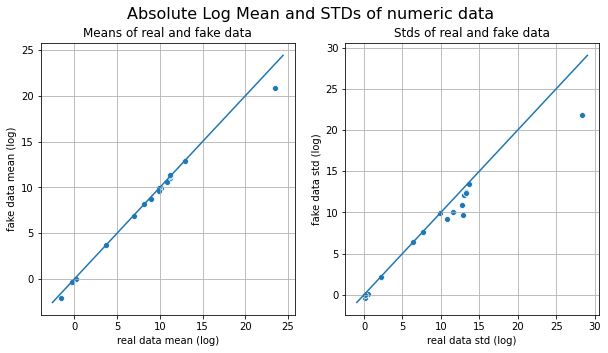

In [51]:
if PLOT_DISTRIBUTIONS:
    evaluator_main.plot_mean_std()

### Data distributions:

Comparison of marginal distributions.

Helper functions:

In [52]:
def compare_distr(data_a, data_b):
    """
    Displays comparison of distributions of two given datasets
    """
    evaluator_real = TableEvaluator(data_a, data_b, cat_cols=cols_cat)
    evaluator_real.plot_distributions()

def compare_distr_by_target(data: pd.DataFrame):
    """
    Displays comparison of distributions of all variables in the dataset, split by the target variable 
    """
    # split the data
    a, b = data[data[TARGET_VAR_NAME] == 0], data[data[TARGET_VAR_NAME] == 1]
    # compare
    compare_distr(a, b)

<hr/>

<b>NOTE</b>: The labels cannot be customized, but the table-evaluator library is the easiest way to compare the datasets. As a result of that, all dataset comparisons use "<b>Fake</b>" and "<b>Real</b>" labels, although they might compare something else.

<hr/>

<b>Real</b> versus <b>synthetic</b> dataset:

In [53]:
if PLOT_DISTRIBUTIONS:
    evaluator_main.plot_distributions()

<b>Real</b> dataset.

<b>GOOD_BAD = 0</b> (plotted as Real) versus <b>GOOD_BAD = 1</b> (plotted as Fake):

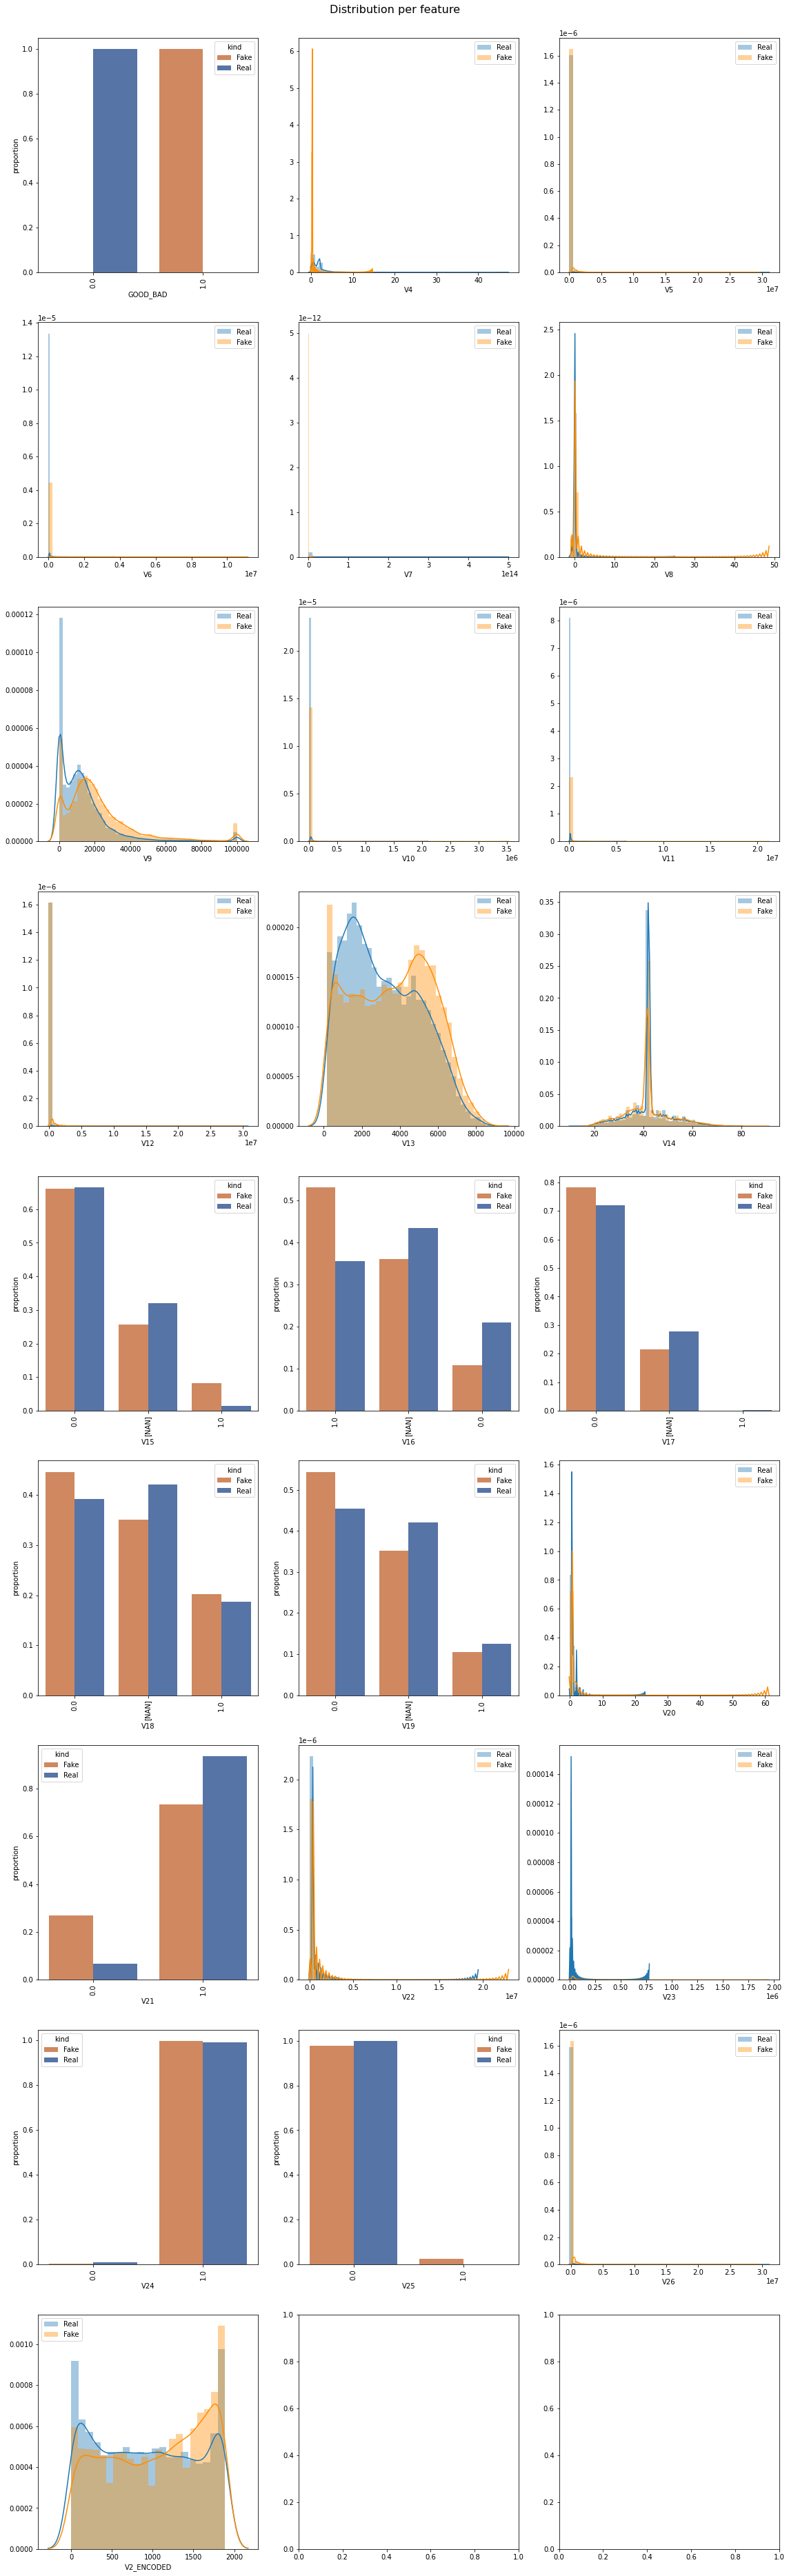

In [54]:
if PLOT_DISTRIBUTIONS:
    compare_distr_by_target(df)

<b>Synthetic</b> dataset.

<b>GOOD_BAD = 0</b> (plotted as Real) versus <b>GOOD_BAD = 1</b> (plotted as Fake):

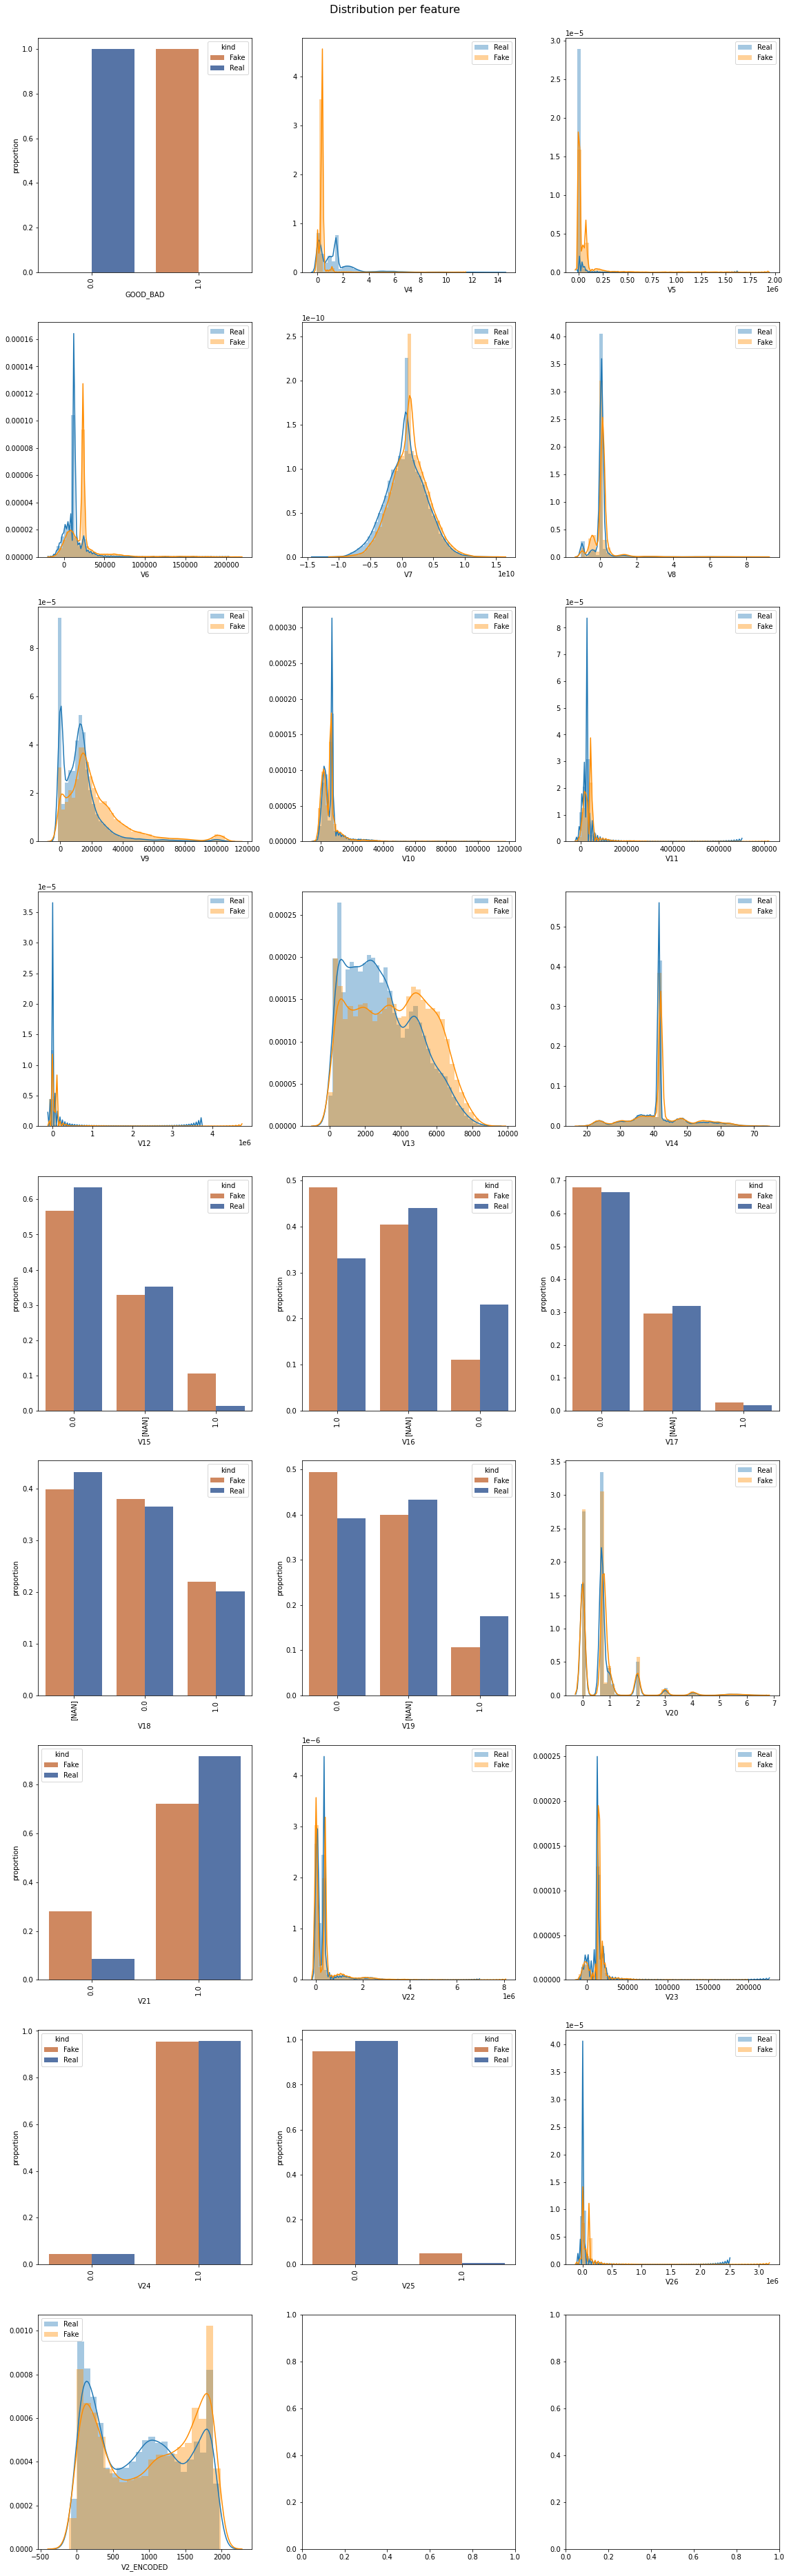

In [55]:
if PLOT_DISTRIBUTIONS:
    compare_distr_by_target(df_synth)

In [56]:
def get_real_synth_by_label(label):
    """
    Returns two datasets. 
    
    first: all data from the real dataset with given label
    second: all data from the sythetic dataset with given label
    """
    real = df_real[df_real[TARGET_VAR_NAME] == label]
    synth = df_synth[df_synth[TARGET_VAR_NAME] == label]
    
    return real, synth

<b>GOOD_BAD = 0</b> dataset.

<b>Real</b> versus <b>synthetic</b> dataset:

In [57]:
if PLOT_DISTRIBUTIONS:
    rs = get_real_synth_by_label(0)
    compare_distr(*rs)

<b>GOOD_BAD = 1</b> dataset.

<b>Real</b> versus <b>synthetic</b> dataset:

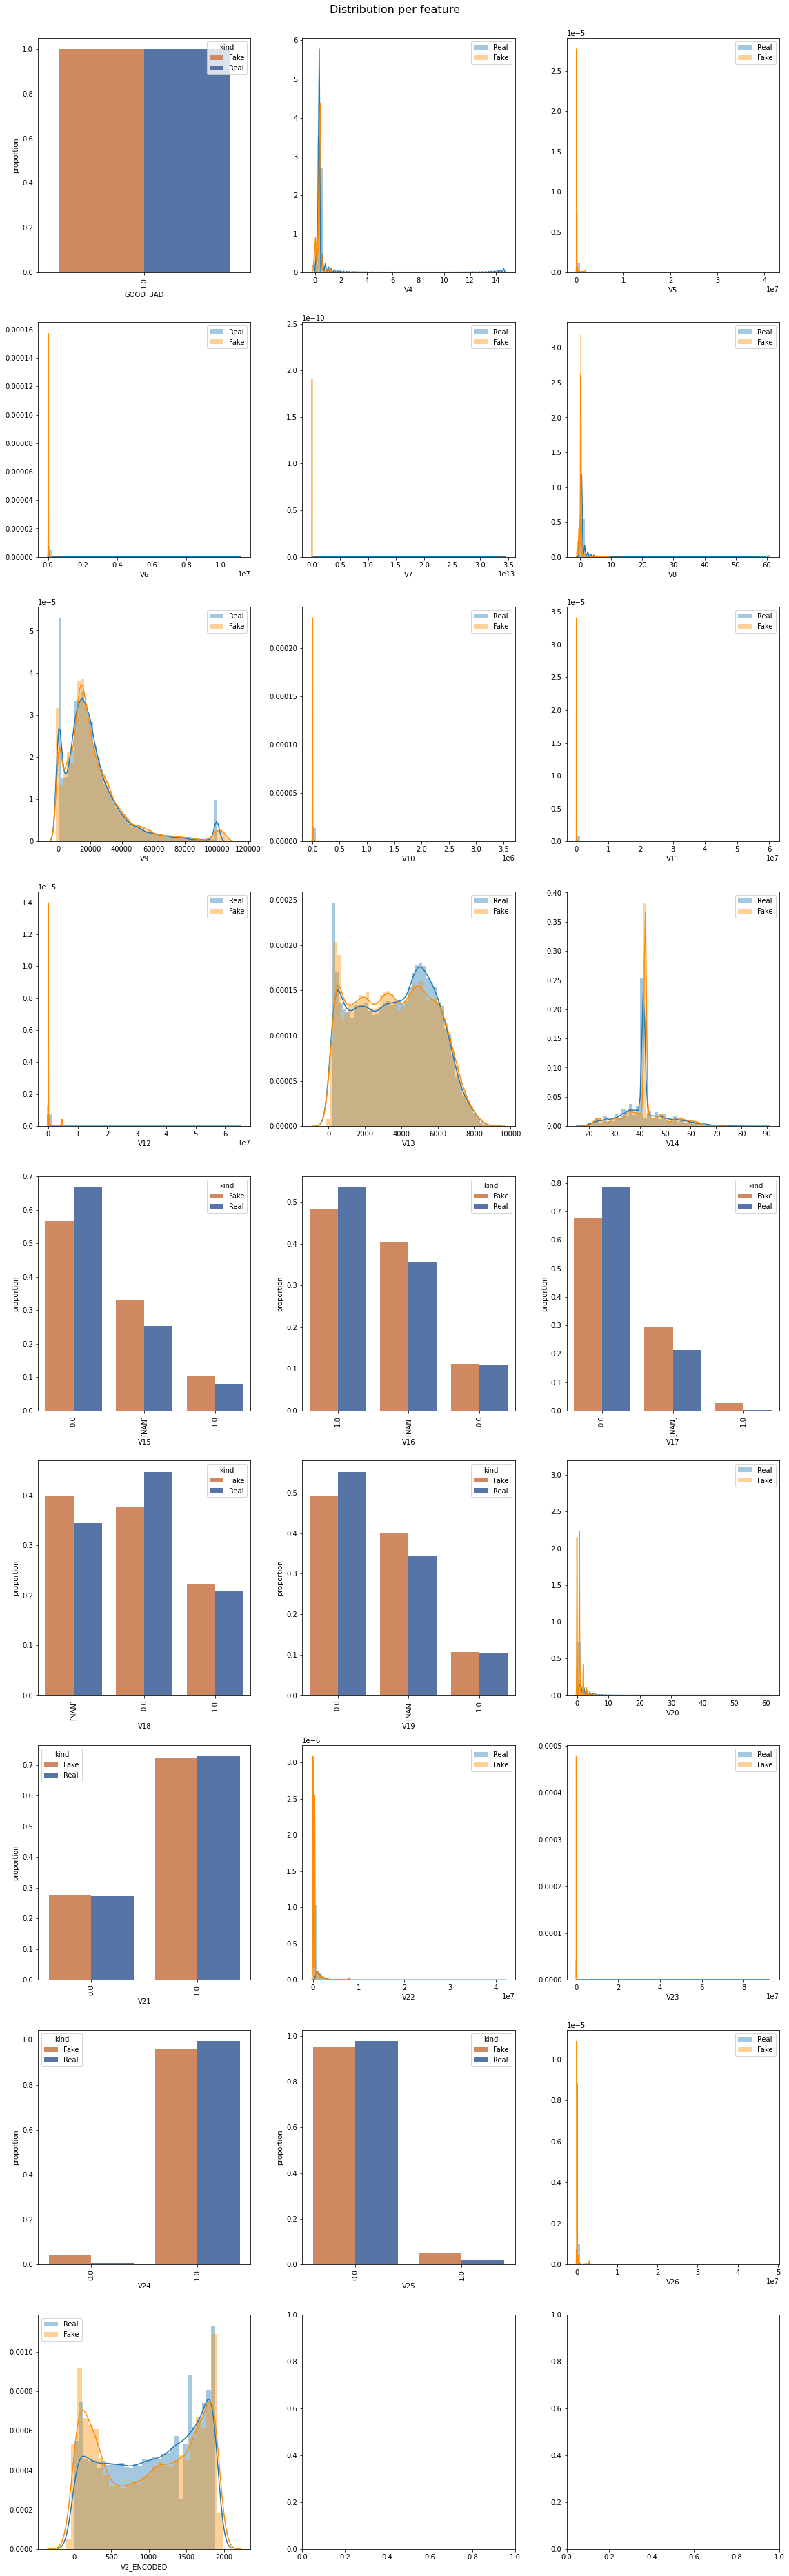

In [58]:
if PLOT_DISTRIBUTIONS:
    rs = get_real_synth_by_label(1)
    compare_distr(*rs)

### SDV evaluation

Changing the data types back:

In [59]:
convert_dtypes(df_real)
convert_dtypes(df_synth)

Tests used for the evaluation:

In [60]:
metrics = [
    'CSTest', 
    'KSTest', 
    'LogisticDetection', 
    'SVCDetection', 
    'ContinuousKLDivergence', 
    'DiscreteKLDivergence'
]

Wrappers:

In [61]:
import sdv.evaluation as sdv_eval
from sdv.metrics.tabular import BinaryDecisionTreeClassifier

@measure_time
def eval_sdv(data_real, data_synth, **kwargs):
    """
    Evaluates data resemblance using default SDV framework evaluation
    
    Wrapper for the sdv.evaluation.evaluate function
    """
    return sdv_eval.evaluate(data_real, data_synth, **kwargs)

@measure_time
def eval_ml_efficacy_sdv(data_real, data_synth):
    """
    Evaluates data resemblance with ML efficacy using simple decission tree 
    """
    return BinaryDecisionTreeClassifier.compute(data_real, data_synth, target=TARGET_VAR_NAME)

#### Complete statistical evaluation:

Different statistical tests results:

In [62]:
if COMPUTE_STATISTICS:
    # sample
    n_rows = int(SDV_EVAL_SPLIT * df_real.shape[0])
    df_real_ = df_real.sample(n_rows)
    df_synth_ = df_synth.sample(n_rows)

    print(f'Number of rows used for the evaluation: {format_ratio(n_rows, df_real.shape[0])}')
    
    # compute result
    score, t = eval_sdv(df_real_, df_synth_, aggregate=False, metrics=metrics)

    print(f'Time of evaluation: {t:.2f} s\n')
    print(f'Separate evaluation scores for all test performed:\n')
    
    display(score)

Number of rows used for the evaluation: 28905 / 57810 ~ 50.00 %
Time of evaluation: 4040.80 s

Separate evaluation scores for all test performed:



metric                                     name  raw_score  \
0                  CSTest                              Chi-Squared   0.412060   
1                  KSTest  Inverted Kolmogorov-Smirnov D statistic   0.886754   
2       LogisticDetection             LogisticRegression Detection   0.761698   
3            SVCDetection                            SVC Detection   0.666812   
4  ContinuousKLDivergence   Continuous Kullback–Leibler Divergence   0.915514   
5    DiscreteKLDivergence     Discrete Kullback–Leibler Divergence   0.313963   

   normalized_score  min_value  max_value      goal  
0          0.412060        0.0        1.0  MAXIMIZE  
1          0.886754        0.0        1.0  MAXIMIZE  
2          0.761698        0.0        1.0  MAXIMIZE  
3          0.666812        0.0        1.0  MAXIMIZE  
4          0.915514        0.0        1.0  MAXIMIZE  
5          0.313963        0.0        1.0  MAXIMIZE

Aggregated score:

In [63]:
if COMPUTE_STATISTICS:
    tmp = score['normalized_score']
    score_agg = tmp.sum() / len(tmp)

    print(f'Aggregated statistics score: {score_agg:.4f}')

Aggregated statistics score: 0.6595


### ML efficacy evaluation 

The implemented version of ML efficacy evaluation uses a simple decision tree as a benchmark. 

All null values are imputed with a placeholder value.

In [64]:
from sklearn.tree import DecisionTreeClassifier

In [65]:
from sklearn import metrics

# placeholders for nan values
nan_placeholder_cat = -1
nan_placeholder_other = -1


def _split_Xy(data: pd.DataFrame): 
    """
    Separates target variable from the rest of the data
    """
    X = data.drop(TARGET_VAR_NAME, axis=1)
    y = data[TARGET_VAR_NAME].astype('int64')
    
    return X, y

def _handle_nulls(data):
    """
    Returns a dataste with no null values
    """
    # select categorical columns
    cat = data.select_dtypes(include='category').columns
    
    for c in data.columns:
        if c in cat:
            # add category first (make sure it is not already added from previous run)
            try:
                data[c] = data[c].cat.add_categories(nan_placeholder_cat)
            except ValueError:
                pass
            
            data[c].fillna(nan_placeholder_cat, inplace=True)
        else:
            data[c].fillna(nan_placeholder_other, inplace=True)
    
    return data

@measure_time
def _train_predict_on(data_train, X_test_, model_class, model_hyperparams={}):
    """
    Trains sklearn model and returns its prediction
    """
    # separate the target variable
    X, y = _split_Xy(data_train)
    
    # train the model
    model = model_class(**model_hyperparams, random_state=RANDOM_SEED)
    model.fit(X, y)
    
    # return the prediction
    return model.predict(X_test_)

def _display_conf_matrix(real, predicted, labels):
    """
    Displays confusion metrics for a classification result
    """
    matrix = metrics.confusion_matrix(real, predicted, labels=labels)
    matrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
    matrix_display.plot()

def eval_ml_efficacy(data_real, data_synth, data_test, verbose=False):
    """
    Evaluates data resemblance using machine learning efficacy
    """
    # null values
    data_real = _handle_nulls(data_real)
    data_synth = _handle_nulls(data_synth)
    data_test = _handle_nulls(data_test)
    
    # separate the target variable from the test data
    X_test, y_test = _split_Xy(data_test)
    
    # train classifier on both dataset s 
    predict_real, t1 = _train_predict_on(data_real, X_test, model_class=DecisionTreeClassifier)
    predict_synth, t2 = _train_predict_on(data_synth, X_test, model_class=DecisionTreeClassifier)
    
    if verbose:
        print(f'Training time of the decission tree: {t1 + t2:.2f} s (real: {t1:.2f} s, synthetic: {t2:.2f} s)')
    # evaluate (f1 works just fine)
    f1_real = metrics.f1_score(y_test, predict_real, pos_label=0)
    f1_synth = metrics.f1_score(y_test, predict_synth, pos_label=0)
    efficacy = f1_synth / f1_real
    if verbose:
        # print result
        print(f'Evaluation complete.\n   real data f1: {f1_real:.4f}\n  synth data f1: {f1_synth:.4f}\n')
        print(f'ML efficacy: {to_percent(efficacy)}')
        # display confusion matrix
        labels = [0, 1]
        _display_conf_matrix(y_test, predict_real, labels=labels)
        _display_conf_matrix(y_test, predict_synth, labels=labels)
        
    return efficacy

Get synthetic train set:

In [66]:
df_synth_train = df_synth.sample(df_train.shape[0])

assert df_train.shape == df_synth_train.shape, 'Both sets have to be equal in size.'

Compute the score:

Training time of the decission tree: 1.96 s (real: 0.90 s, synthetic: 1.05 s)
Evaluation complete.
   real data f1: 0.5746
  synth data f1: 0.5713

ML efficacy: 99.43 %


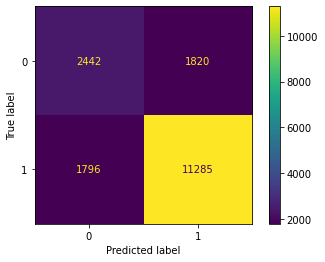

In [67]:
if COMPUTE_ML_EFFICACY:
    score_ml_eff = eval_ml_efficacy(df_train, df_synth_train, df_test, verbose=True)

## Final convertion to the original format

The columns modified in the preprocessing need to be converted back. 

Since the original dataset is very clean, only the date column has to be converted back to obtain the original dataset format. Altough many float values originally used <b>','</b> instead of <b>'.'</b>, it is not converted back iin this part, because the values are meant to represent real numbers anyway.

### Date Column

The **DateConverter** object defined in the preprocessing part of this notebook is used to decode the date column back to its original format.

In [68]:
if date_col_encoded in df_synth.columns:
    convert_dtypes(df_synth_raw)
    df_synth_raw[date_col] = date_converter.decode(df_synth_raw[date_col_encoded])
    df_synth_raw.drop(date_col_encoded, axis=1, inplace=True)

# display
df_synth_raw[date_col].apply(lambda x : x.date()).head()

0    2013-06-29
1    2011-02-28
2    2013-06-05
3    2011-08-21
4    2013-11-08
Name: V2, dtype: object

Final look at the data:

In [69]:
df_synth_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57810 entries, 0 to 57809
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   level_0     57810 non-null  int64         
 1   index       57810 non-null  int64         
 2   GOOD_BAD    57810 non-null  category      
 3   V4          22596 non-null  float64       
 4   V5          48525 non-null  float64       
 5   V6          37390 non-null  float64       
 6   V7          54135 non-null  float64       
 7   V8          19788 non-null  float64       
 8   V9          57810 non-null  int64         
 9   V10         40374 non-null  float64       
 10  V11         40374 non-null  float64       
 11  V12         40374 non-null  float64       
 12  V13         57810 non-null  int64         
 13  V14         34149 non-null  float64       
 14  V15         38433 non-null  category      
 15  V16         33840 non-null  category      
 16  V17         40374 non-

### Saving generated data

In [70]:
df_synth_raw.to_csv(DATA_PATH_SYNTH_FINAL, index=False) 